# Data
The provided is data is cleaned and reformatted to facilitate further use by a cleaning function. 

This function can be found in *datacleaner.py*.

It also enabled creation of a train and test set via a *max_time* argument which exlucdes observations later than the specified date.

Below we create a training set including data up to 2017.

In [1]:
from datacleaner import DataCreator
DataCreator(max_time='2017')

# Backtesting environment
A complete backtesting environment which allows for easy testing of different strategies. This can be found in *backtesting.py*. The environment is modular and works by feeding price and financial data to user-defined strategies. Starting from the beginning of the dataset, the environment gives the strategy a variable amount of historical price and financial data depending on user preference. A strategy is then required to return a series of allocations based on this data. From these series, the environment will calculate the returns of the strategy.

The adjustable parameters for testing are:
- n_prices : how many months of price data to take into account
- n_ratios : how many months of financial data to take into account
- frequency : how often we want to trade


The environment also allows for analysis of the strategy returns and can generate multiple plots and metrics for any given strategy, also comparing them to a market benchmark, which will be illustrated below.

To ensure validity of further results we want to ensure that our backtesting environment is working as intended. This is done by comparing backtest returns from a mock strategy which invests in entire market to a simple mean of the returns from the data. If the backtests results are (roughly) the same as the mean it indicates that the backtest module is working as intended.

100%|██████████| 323/323 [00:01<00:00, 193.99it/s]


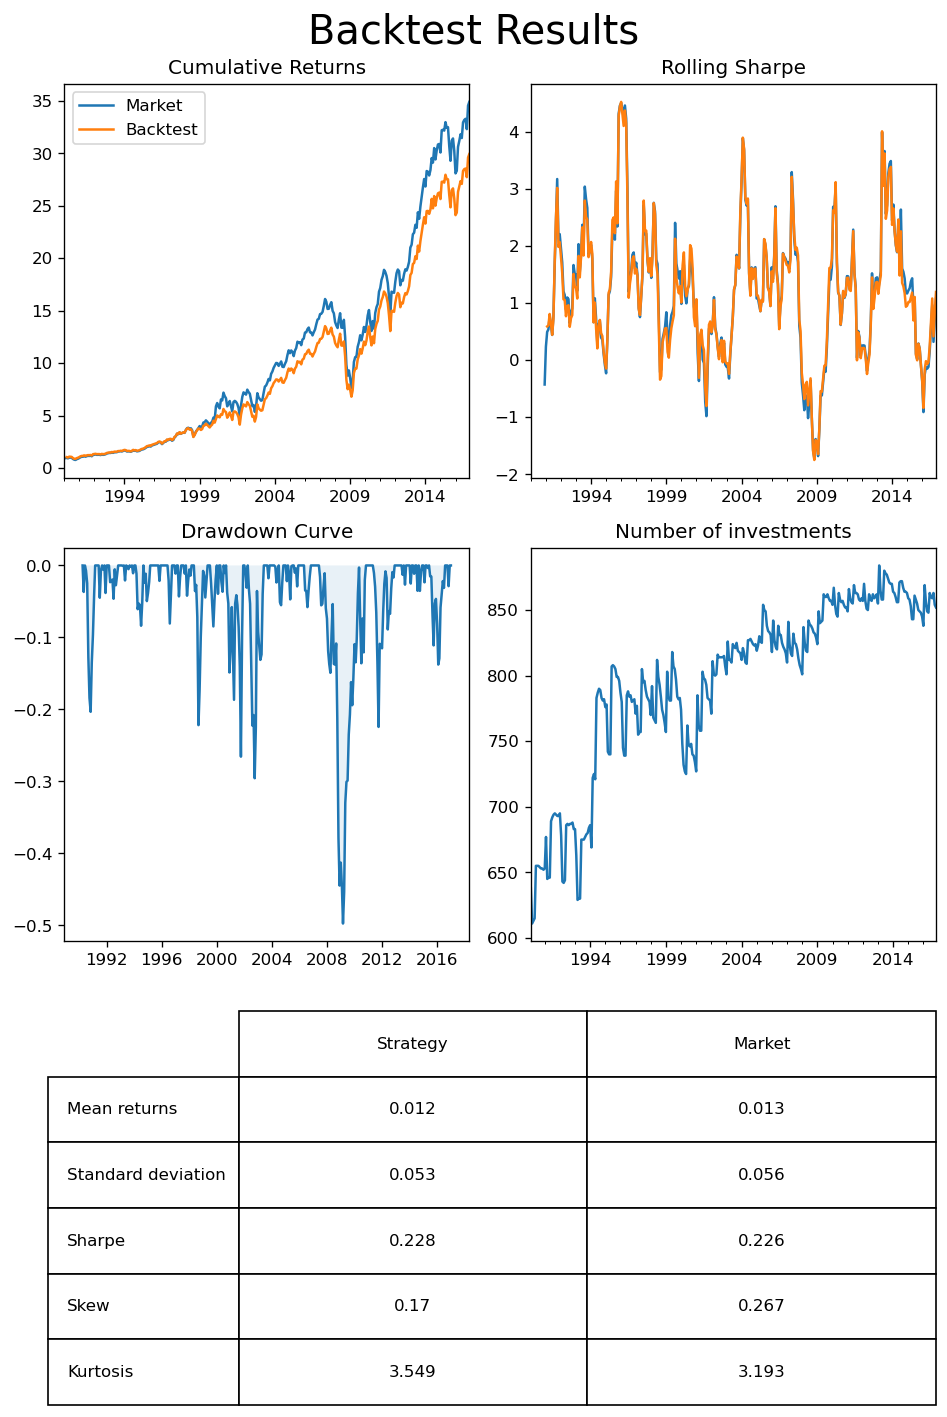

In [2]:
import pandas as pd
from backtest import BackTester

def entire_market(prices, ratios):
    """
    simply strategy to buy an equal amount 
    of all available stocks at any given time
    """
    all_stocks = prices['permno'].unique()
    return pd.Series({s:1/len(all_stocks) for s in all_stocks})

# initialise backtest object
backtester = BackTester()

# run backtest with entire_market strategy
backtester.rolling_test(
    strategy=entire_market,
    n_prices=1, 
    frequency=1
)

# analyse backtest results
metrics = backtester.analyse()

The backtest of the entire market strategy performs slightly worse than the mean of the returns. 

This is probably due to some data points getting taken out from the backtest as data points are missing. However, the cumulative returns are very similar and the backtesting class seems to be working as intended.

# Our Cluster Momentum strategy

With a working backtesting system in place we created an investment strategy. The strategy combines data science and finance and consists of multiple steps which are executed as follows:

1. For any given point in time the strategy receives $n$ months of price and data and one month of financial data.
2. Financial data is standardised (0 mean, 1 variance) and passed through principal component analysis to reduce it's dimensionality, preserving $v$ variance.
3. Reduced financial data is used to classify the different stocks into $k$ different clusters.
4. Stocks are ordered by their total return over the $n$ months.
5. The stock with the highest returns from each individual cluster is placed into a portfolio and the Sharpe ratio of this portfolio over the $n$ months is calculated.
6. If it increases the Sharpe ratio, another stock from each clusted is added to the portfolio. This is done iteratively until it does not improve the Sharpe ratio.
7. Once the best amount of stocks is found, all stocks are given an equal proportion of the portfolio. For the time being, the strategy only takes long positions.

Given the structure of the strategy as well as the backtesting environment, there are a few variable parameters:

- $n$ : the number of months of price data to include, this namely affects the calculation of return and Sharpe ratios, this is passed to the backtesting environment
- $f$ : the frequency of trading, this is passed to the backtesting environment.
- $v$ : the amount of variance which is preserved when performing principal component analysis.
- $k$ : the number of clusters which are created.

Below these parameters are chosen arbitrarily in a first attempt, however, we will later try to optimise them to improve returns.

100%|██████████| 321/321 [00:13<00:00, 22.97it/s]


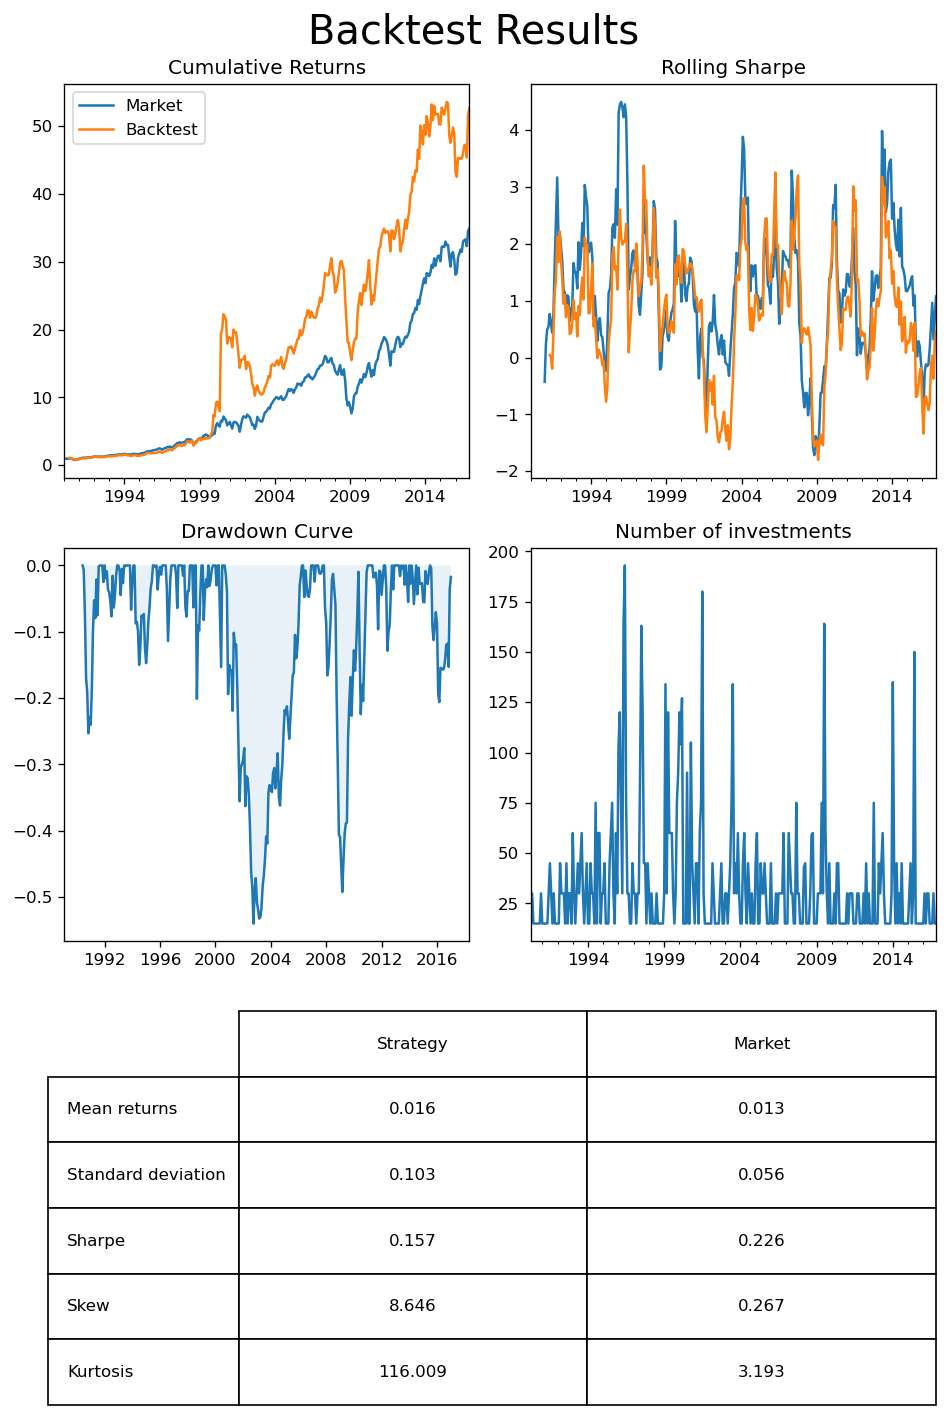

In [3]:
from strategy import ClusterMomentum

n = 3
f = 1
v = 0.9
k = 15

# create new backtester object
backtester = BackTester()

# create strategy object
clustermomentum = ClusterMomentum(n_clusters=k, variance=v)

# run backtest
backtester.rolling_test(
    strategy=clustermomentum.strategy,
    n_prices=n,
    frequency=f
)

# analyse backtest results
metrics = backtester.analyse()

The first attempt of the strategy proved very volatile. While it in total delivered greater cumulative returns than the market. It does this at the cost of a significant increase in the standard deviation, which leads to it having a smaller Sharpe ratio than the general market. This is also emphasised by the immense kurtosis of the returns, which is significantly larger than that of the market. The frequent large losses are also illustrated in the drawdown curve.

# Bayesian optimisation

In [ ]:
import optuna

def objective(trial):
    # Define the search space for your hyperparameters
    variance = trial.suggest_float('variance', 0, 1)
    n_clusters = trial.suggest_int('clusters', 1, 25)

    n_prices = trial.suggest_int('n_prices', 2, 12)
    frequency = trial.suggest_int('frequency', 1, 12)


    # Call your random function with the suggested hyperparameters
    investments = investment_strategy(
        n_clusters=n_clusters,
        variance=variance)

    backtester.rolling_test(
        decision_function=investments.strategy,
        n_prices=n_prices,
        frequency=frequency)
    
    result = backtester.analyse()['Sharpe']

    # Return the result as the score for Optuna to use in its search
    return result

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)